# Libraries

In [1]:
import numpy as np
import pandas as pd
import pr2_utils
import time
import matplotlib.pyplot as plt

# Accessing Sensor Files

In [2]:
with open('final_x.npy', 'rb') as f:
    a = np.load(f)
print(a)

[0.00000000e+00 4.58826537e-02 9.17653070e-02 ... 1.09436725e+03
 1.09441174e+03 1.09445561e+03]


In [3]:
with open('final_y.npy', 'rb') as f:
    b = np.load(f)
print(b)

[ 0.00000000e+00 -3.93901819e-06 -1.15742960e-05 ... -5.13367416e+02
 -5.13419926e+02 -5.13471705e+02]


In [4]:
positions=np.stack((a,b))

In [5]:
with open('cumulativeYaw_sync.npy', 'rb') as f:
    cumulativeYaw_sync= np.load(f)
print(cumulativeYaw_sync.shape)

(115865,)


In [6]:
with open('lidar2VehicleTensor.npy', 'rb') as f:
    lidar2VehicleTensor = np.load(f)
print(lidar2VehicleTensor.shape)

(4, 286, 115865)


# World to Grid-Cell Function

In [7]:
def filter(matrix):
    xs0= matrix[0,:]
    ys0= matrix[1,:]
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int32)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int32)-1

    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    return np.vstack((xis,yis))

# Lidar Mapping to Grid Function

In [8]:
#obstacleList=[]

def mapping(timeFrame):
    # for an arbitrary row, mapping comes in the row after
    initial_point_x = 0
    initial_point_y = 0
    
    cumulativeYaw_t=cumulativeYaw_sync[timeFrame]
    R=np.array([[np.cos(cumulativeYaw_t), -np.sin(cumulativeYaw_t),0 ],[np.sin(cumulativeYaw_t), np.cos(cumulativeYaw_t),0 ],[0,0,1]])
    P= np.array([positions[0,timeFrame],positions[1,timeFrame],0]).reshape(3,1)
    
    worldLidarMatrix=np.zeros((2,286))
    S_T_V= np.block([
    [R,               P],
    [np.zeros((1, 3)), 1               ]
    ])
    
    W_T_S= np.block([
    [np.eye(3),               np.array([0.335,0.035, -0.78]).reshape(3,1)],
    [np.zeros((1, 3)), 1               ]
    ])
    
    
    if(timeFrame== -1):
        worldLidarMatrix=lidar2VehicleTensor[:,:,0][[0,1],:]
        initial_point_x= np.ceil((0 - MAP['xmin']) / MAP['res'] ).astype(np.int32)-1
        initial_point_y = np.ceil((0 - MAP['ymin']) / MAP['res'] ).astype(np.int32)-1
    
        
    else:        
        worldLidarMatrix=W_T_S@S_T_V@lidar2VehicleTensor[:,:,timeFrame+1]
        initial_point_x= np.ceil((positions[0,timeFrame] - MAP['xmin']) / MAP['res'] ).astype(np.int32)-1
        initial_point_y = np.ceil((positions[1,timeFrame] - MAP['ymin']) / MAP['res'] ).astype(np.int32)-1
        #print(initial_point_x,initial_point_y)
        
    cells_worldLidarMatrix=filter(worldLidarMatrix)
    #print(cells_worldLidarMatrix)
    
    for i in range(cells_worldLidarMatrix.shape[1]):
        bresOutput=pr2_utils.bresenham2D(initial_point_x,initial_point_y,cells_worldLidarMatrix[0,i],cells_worldLidarMatrix[1,i]).astype(np.int32)
        #print(bresOutput.shape)
        #indGood = np.logical_and(np.logical_and(np.logical_and((bresOutput[0,:] > 1), (bresOutput[1,:] > 1)), (bresOutput[0,:] < MAP['sizex'])), (bresOutput[1,:] < MAP['sizey']))
        #bresOutput= bresOutput[:,indGood]
    
        obstacles= bresOutput[:,-1].astype(np.int32)
        MAP['map'][bresOutput[0,:],bresOutput[1,:],:] = np.array([255,255,255])
        MAP['map'][int(obstacles[0]),int(obstacles[1]),:] = np.array([0,0,0])  
        #obstacleList.append(np.array([int(obstacles[0]),int(obstacles[1])]))

# Dead Reckoning: Main

size x: 1401
size y: 1401


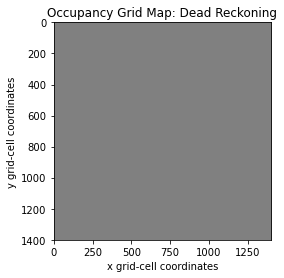

iteration:  50000


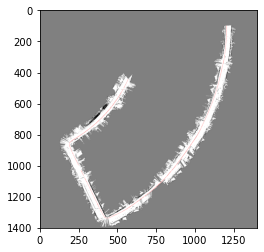

iteration:  100000


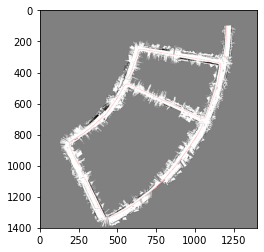

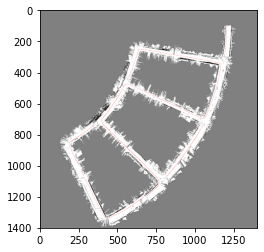

In [9]:
# init MAP
#%matplotlib qt

MAP = {}
MAP['res']   = 1 #meters
MAP['xmin']  = -100  #meters
MAP['ymin']  = -1200
MAP['xmax']  =  1300
MAP['ymax']  =  200
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
print("size x:", MAP['sizex'])
print("size y:", MAP['sizey'])
MAP['map'] = 128*np.ones((MAP['sizex'],MAP['sizey'],3), dtype=np.int32) #DATA TYPE: char or int8
plt.title("Occupancy Grid Map: Dead Reckoning")
plt.xlabel("x grid-cell coordinates")
plt.ylabel("y grid-cell coordinates")
plt.imshow(MAP['map'])
plt.pause(0.01)
plt.show()
plt.pause(2)


positions_cells= filter(np.vstack((positions[0,:], positions[1,:])))

#max 115865
for i in range(1,115865):    
    #print("iter:", i)
    #pseudo predict
    MAP['map'][positions_cells[0,i],positions_cells[1,i]] = np.array([255,0,0])
    if(i%5==0):
        mapping(i)
    
    if(i%50000==0):
        print('iteration: ', i)
        
        plt.imshow(MAP['map'])
        plt.pause(0.01)

plt.imshow(MAP['map']);
plt.show()

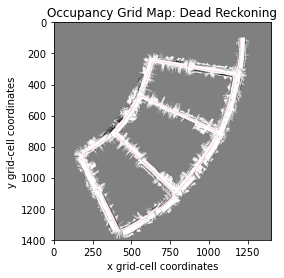

In [10]:
plt.title("Occupancy Grid Map: Dead Reckoning")
plt.xlabel("x grid-cell coordinates")
plt.ylabel("y grid-cell coordinates")
plt.imshow(MAP['map']);
plt.show()